# Final Project - Steve's Notebook

MIDS w261: Machine Learning at Scale | UC Berkeley School of Information | Spring 2019

Final Project: Click Through Rate Prediction

Helpful references:  
https://github.com/elsyifa/Classification-Pyspark  
https://docs.databricks.com/spark/latest/mllib/binary-classification-mllib-pipelines.html  
https://medium.com/@_moazzemhossain/machine-learning-cheat-sheets-for-ml-engineers-data-scientist-d44a43f65979  

In [5]:
spark   # use this on cluster

In [6]:
sc = spark.sparkContext   # use this on the cluster

In [7]:
import re
import ast
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyspark.sql.functions as F
from pyspark.sql import types

In [8]:

from pyspark.sql import types, Row, Column
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, LogisticRegressionModel, RandomForestClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [2]:
# start Spark Session
'''
from pyspark.sql import SparkSession
app_name = "finalProject"
master = "local[*]"
spark = SparkSession\
        .builder\
        .appName(app_name)\
        .master(master)\
        .getOrCreate()
sc = spark.sparkContext
'''

##### Download data from the source.  

In [21]:
### Create data directory and download data from the source: http://labs.criteo.com/2014/09/kaggle-contest-dataset-now-available-academic-use/
#https://s3-eu-west-1.amazonaws.com/kaggle-display-advertising-challenge-dataset/dac.tar.gz 

In [4]:
!wc -l data/train.txt

45840617 data/train.txt


In [5]:
!wc -l data/test.txt

6042135 data/test.txt


## Read in small sample and apply Logistic Regression

In [42]:
small_sample_train = spark.read.parquet('data/smallTrainSample.parquet')

In [178]:
small_sample_train.head()

Row(label=0.0, n0=0.0, n1=0.0001595405232929164, n2=0.0, c8='8418', c19='None', c8_idx=1.0, c19_idx=0.0, c8_OHE=SparseVector(2, {1: 1.0}), c19_OHE=SparseVector(4, {0: 1.0}), features=SparseVector(9, {1: 0.0002, 4: 1.0, 5: 1.0}))

In [44]:
from pyspark.ml.classification import LogisticRegression

In [179]:
lr_small = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
lr_small_model = lr_small.fit(small_sample_train)

In [47]:
trainingSummary_small = lr_small_model.summary

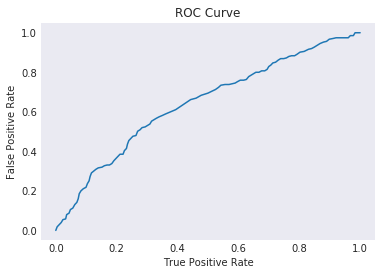

Training set ROC: 0.6418060064935066


In [50]:
roc = trainingSummary_small.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set ROC: ' + str(trainingSummary_small.areaUnderROC))

In [133]:
objectiveHistory = trainingSummary_small.objectiveHistory

In [134]:
objectiveHistory

[0.5450611331247501,
 0.537565676579473,
 0.5304127789669243,
 0.5282731281354065,
 0.5281851892167337,
 0.5281285054262518,
 0.5281036067941927,
 0.5280990332504583,
 0.5280982040098371,
 0.528098125623702,
 0.5280981244932045]

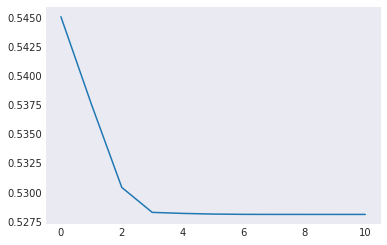

In [136]:
plt.plot(objectiveHistory)

In [51]:
# Read in small test set
small_sample_test = spark.read.parquet('data/smallTestSample.parquet')

In [52]:
small_sample_test.head()

Row(label=0.0, n0=0.0, n1=0.0, n2=0.006, c8='6944', c19='3834', c8_idx=0.0, c19_idx=1.0, c8_OHE=SparseVector(2, {0: 1.0}), c19_OHE=SparseVector(4, {1: 1.0}), features=SparseVector(9, {2: 0.006, 3: 1.0, 6: 1.0}))

In [53]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

predictions_lr_small = lr_small_model.transform(small_sample_test)
evaluator = BinaryClassificationEvaluator()
print("Test_SET (Area Under ROC): " + str(evaluator.evaluate(predictions_lr_small, {evaluator.metricName: "areaUnderROC"})))

Test_SET (Area Under ROC): 0.6077074937608637


In [142]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

lr_eval2 = MulticlassClassificationEvaluator()
print("test set Accuracy:", str(lr_eval2.evaluate(predictions_lr_small, {lr_eval2.metricName: "accuracy"}))  )

test set Accuracy: 0.742498794018331


In [143]:
lr_eval2.params

[Param(parent='MulticlassClassificationEvaluator_4ff9a10c9236f9d8e0b1', name='labelCol', doc='label column name.'),
 Param(parent='MulticlassClassificationEvaluator_4ff9a10c9236f9d8e0b1', name='metricName', doc='metric name in evaluation (f1|weightedPrecision|weightedRecall|accuracy)'),
 Param(parent='MulticlassClassificationEvaluator_4ff9a10c9236f9d8e0b1', name='predictionCol', doc='prediction column name.')]

In [148]:
print("test set Precision??:", str(lr_eval2.evaluate(predictions_lr_small, {lr_eval2.metricName: "weightedPrecision"}))  )
print("test set Recall??:", str(lr_eval2.evaluate(predictions_lr_small, {lr_eval2.metricName: "weightedRecall"}))  )
print("test set f1??:", str(lr_eval2.evaluate(predictions_lr_small, {lr_eval2.metricName: "f1"}))  )

test set Precision??: 0.6925564115693119
test set Recall??: 0.742498794018331
test set f1??: 0.6440633582469697


In [97]:
evaluator.params

[Param(parent='BinaryClassificationEvaluator_477a89b94c65ffbe023e', name='labelCol', doc='label column name.'),
 Param(parent='BinaryClassificationEvaluator_477a89b94c65ffbe023e', name='metricName', doc='metric name in evaluation (areaUnderROC|areaUnderPR)'),
 Param(parent='BinaryClassificationEvaluator_477a89b94c65ffbe023e', name='rawPredictionCol', doc='raw prediction (a.k.a. confidence) column name.')]

In [61]:
counttotal = predictions_lr_small.count()
print('count total:', counttotal)

count total: 10365


In [238]:
lp = predictions_lr_small.select( "label", "prediction")

In [72]:
correct = lp.filter(lp["label"] == lp["prediction"]).count()
print('correct:', correct)

correct: 7696


In [70]:
print('accuracy:', correct/float(counttotal))

accuracy: 0.742498794018331


In [237]:
def metricsCalc(lp):
    '''
    Calculate binary classification metrics
    '''
    
    trueP = lp.filter(lp["prediction"] == 1.0).filter(lp["label"] == lp["prediction"]).count()
    trueN = lp.filter(lp["prediction"] == 0.0).filter(lp["label"] == lp["prediction"]).count()
    falseP = lp.filter(lp["prediction"] == 1.0).filter(lp["label"] != lp["prediction"]).count()
    falseN = lp.filter(lp["prediction"] == 0.0).filter(lp["label"] != lp["prediction"]).count()

    # Calculate precision, recall, accuracy, and F1
    precision = float(trueP)/(trueP + falseP) # aka specificity
    recall = float(trueP)/(trueP + falseN)  # aka sensitivity
    accuracy = float(trueP + trueN)/(trueP + trueN + falseP + falseN)
    if trueP != 0:
        f1 = 2 * (precision * recall) / (precision + recall)  # if trueP=0, then precision=0 and recall=0, so f1 doesn't work.
    else:
        f1 = 'TP=0 so cannot calc f1'

    # prints
    print('Number of records:', (trueP+falseP+trueN+falseN))
    print(f'trueP\t\t{trueP}')
    print(f'trueN\t\t{trueN}')
    print(f'falseP\t\t{falseP}')
    print(f'falseN\t\t{falseN}')
    print(f'accuracy\t{accuracy}')
    print(f'precision\t{precision}')
    print(f'recall\t\t{recall}')
    print(f'f1\t\t{f1}')

In [239]:
lp_small = predictions_lr_small.select( "label", "prediction")
metricsCalc(lp_small)

Number of records: 10365
trueP		71
trueN		7625
falseP		60
falseN		2609
accuracy	0.742498794018331
precision	0.5419847328244275
recall		0.026492537313432835
f1		0.050515830665243684


In [110]:
trainingSummary_small.labelCol

'label'

In [111]:
trainingSummary_small.probabilityCol

'probability'

In [127]:
l_all = predictions_lr_small.select( "label", "probability", "prediction")

In [128]:
l_all.show()

+-----+--------------------+----------+
|label|         probability|prediction|
+-----+--------------------+----------+
|  0.0|[0.72835492125822...|       0.0|
|  0.0|[0.85613433044258...|       0.0|
|  0.0|[0.85613433044258...|       0.0|
|  0.0|[0.85613433044258...|       0.0|
|  0.0|[0.85613433044258...|       0.0|
|  0.0|[0.85613433044258...|       0.0|
|  0.0|[0.83191078863056...|       0.0|
|  0.0|[0.83191078863056...|       0.0|
|  0.0|[0.75988364274687...|       0.0|
|  0.0|[0.75988364274687...|       0.0|
|  0.0|[0.75988364274687...|       0.0|
|  0.0|[0.75988364274687...|       0.0|
|  0.0|[0.75988364274687...|       0.0|
|  0.0|[0.75988364274687...|       0.0|
|  0.0|[0.72466576308662...|       0.0|
|  0.0|[0.72466576308662...|       0.0|
|  0.0|[0.76344505299742...|       0.0|
|  0.0|[0.85638677270010...|       0.0|
|  0.0|[0.85671346801646...|       0.0|
|  0.0|[0.91908787911567...|       0.0|
+-----+--------------------+----------+
only showing top 20 rows



In [129]:
l_all.head()

Row(label=0.0, probability=DenseVector([0.7284, 0.2716]), prediction=0.0)

In [130]:
l_pos = l_all.filter(l_all['prediction']==1.0)

In [131]:
l_pos.show()

+-----+--------------------+----------+
|label|         probability|prediction|
+-----+--------------------+----------+
|  0.0|[0.44621554094092...|       1.0|
|  0.0|[0.24772169653926...|       1.0|
|  0.0|[0.19063332156566...|       1.0|
|  1.0|[0.45309698836657...|       1.0|
|  1.0|[0.19039937972810...|       1.0|
|  1.0|[0.00194481278906...|       1.0|
|  1.0|[1.14196272400034...|       1.0|
|  0.0|[0.19737483092537...|       1.0|
|  1.0|[0.47917578826940...|       1.0|
|  1.0|[0.49959284605317...|       1.0|
|  1.0|[0.21280156310072...|       1.0|
|  0.0|[0.49792602431280...|       1.0|
|  0.0|[0.42104827076934...|       1.0|
|  0.0|[0.40536553221745...|       1.0|
|  0.0|[0.39138954435492...|       1.0|
|  0.0|[0.27318312628595...|       1.0|
|  0.0|[0.19603620545852...|       1.0|
|  1.0|[0.46583281417288...|       1.0|
|  1.0|[0.41195922161647...|       1.0|
|  0.0|[0.47897508566274...|       1.0|
+-----+--------------------+----------+
only showing top 20 rows



In [132]:
l_pos.head()

Row(label=0.0, probability=DenseVector([0.4462, 0.5538]), prediction=1.0)

In [90]:
# Log loss

def logloss(true_label, predicted_prob):
  
    epsilon = 10^(-15)
    predicted_prob = max(min(predicted_prob, 1-epsilon), epsilon)
    
    if true_label == 1:
        return -log(predicted_prob)
    else:
        return -log(1 - predicted_prob)

In [109]:
trainingSummary_small
#print(trainingSummary_small)

In [101]:
# feature importance

# https://spark.apache.org/docs/2.2.0/ml-classification-regression.html

print('intercept:', lr_small_model.intercept)
print('coefficients:', lr_small_model.coefficients)


intercept: -1.2282349801739665
coefficients: [2.8687282487666583,0.6751681978279879,-3.0766032897750923,0.050258493422503256,-0.5812470924213744,0.025827077895429925,0.21014400455738527,0.006208130249914411,-0.5960309219171409]


In [157]:
small_sample_train.columns

['label',
 'n0',
 'n1',
 'n2',
 'c8',
 'c19',
 'c8_idx',
 'c19_idx',
 'c8_OHE',
 'c19_OHE',
 'features']

#### regularization and cross validation

In [153]:
# Logisitic Regression with Regularization and Cross Validation for Hyperparameter Tuning

from pyspark.ml.tuning import CrossValidator, ParamGridBuilder 

lr_small_reg = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)

paramGrid_lr = ParamGridBuilder() \
    .addGrid(lr_small_reg.regParam, [0.01, 0.1, 1.0]) \
    .addGrid(lr_small_reg.elasticNetParam, [0.5, 0.7, 0.9]) \
    .build()

crossval_lr_small = CrossValidator(estimator=lr_small_reg,
                             estimatorParamMaps=paramGrid_lr,
                             evaluator=BinaryClassificationEvaluator(),
                             numFolds=5)

#fit model to training data
lr_small_reg_model = crossval_lr_small.fit(small_sample_train)

#Transform test data
lr_small_reg_result = lr_small_reg_model.transform(small_sample_test)

#view id, label, prediction and probability from result of modeling
lr_small_reg_result.select('label', 'prediction', 'probability').show(10)


+-----+----------+--------------------+
|label|prediction|         probability|
+-----+----------+--------------------+
|  0.0|       0.0|[0.75004694775605...|
|  0.0|       0.0|[0.82726170576101...|
|  0.0|       0.0|[0.82726170576101...|
|  0.0|       0.0|[0.82726170576101...|
|  0.0|       0.0|[0.82726170576101...|
|  0.0|       0.0|[0.82726170576101...|
|  0.0|       0.0|[0.81700622602457...|
|  0.0|       0.0|[0.81700622602457...|
|  0.0|       0.0|[0.76224960882026...|
|  0.0|       0.0|[0.76224960882026...|
+-----+----------+--------------------+
only showing top 10 rows



In [167]:
print('Best Hyperparameters for Small Sample dataset')
print("best regParam:", lr_small_reg_model.bestModel.regParam)
print("best elasticNetParam:", lr_small_reg_model.bestModel.elasticNetParam)

Best Hyperparameters for Small Sample dataset
best regParam: LogisticRegression_4542b0fd3fd28f383cc3__regParam
best elasticNetParam: LogisticRegression_4542b0fd3fd28f383cc3__elasticNetParam


In [236]:
#lr_small_reg_model.getEstimatorParamMaps()

In [175]:
lr_small_reg_model.getEstimatorParamMaps()[ np.argmax(lr_small_reg_model.avgMetrics) ]

{Param(parent='LogisticRegression_4542b0fd3fd28f383cc3', name='regParam', doc='regularization parameter (>= 0).'): 0.01,
 Param(parent='LogisticRegression_4542b0fd3fd28f383cc3', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.9}

#### Best hyperparameters for small sample: regParam = 0.01; elasticNetParam = 0.9.

In [217]:
print('intercept:', lr_small_reg_model.bestModel.intercept)
print('coefficients:', lr_small_reg_model.bestModel.coefficients)

intercept: -1.2090852455788703
coefficients: [2.478052796049695,0.06401468125312675,-0.6580943688652904,0.04402230673054404,-0.3572683651957661,0.0,0.07014881268525996,0.0,-0.48191783947288547]


In [156]:
lp_reg = lr_small_reg_result.select( "label", "prediction")
metricsCalc(lp_reg)

Number of records: 10365
trueP		56
trueN		7641
falseP		44
falseN		2624
accuracy	0.7425952725518572
precision	0.56
recall		0.020895522388059702
f1		0.040287769784172665


## Read in (medium) sample and apply Logistic Regression

In [196]:
### NOTE: Per Alex, train and test are reversed, so read them in reverse order.
sample_train = spark.read.parquet('data/testSample.parquet')
sample_test = spark.read.parquet('data/trainSample.parquet')

In [184]:
sample_train.head()

Row(label=0.0, n0=0.0, n1=0.0, n2=0.00016070711128967456, n3=0.03424657534246575, n4=0.0025729368529526933, n5=0.0, n6=0.0, n7=0.017241379310344827, n8=0.0016054227613271496, n9=0.0, n10=0.0, n11=0.0, n12=0.016778523489932886, c0='5684', c1='8609', c2='9077', c3='6365', c4='4903', c5='2646', c6='2630', c7='84', c8='6944', c9='8539', c10='5511', c11='1635', c12='6300', c13='2527', c14='5306', c15='7065', c16='4857', c17='2077', c18='None', c19='None', c20='2164', c21='None', c22='4324', c23='1592', c24='None', c25='None', c0_idx=0.0, c1_idx=222.0, c2_idx=2612.0, c3_idx=6.0, c4_idx=1.0, c5_idx=1.0, c6_idx=1128.0, c7_idx=0.0, c8_idx=0.0, c9_idx=0.0, c10_idx=1061.0, c11_idx=1297.0, c12_idx=1076.0, c13_idx=1.0, c14_idx=1333.0, c15_idx=556.0, c16_idx=4.0, c17_idx=844.0, c18_idx=0.0, c19_idx=0.0, c20_idx=260.0, c21_idx=0.0, c22_idx=4.0, c23_idx=2.0, c24_idx=0.0, c25_idx=0.0, c19_OHE=SparseVector(4, {0: 1.0}), c6_OHE=SparseVector(1950, {1128: 1.0}), c16_OHE=SparseVector(10, {4: 1.0}), c10_OHE=

In [186]:
sample_test.head()

Row(label=0.0, n0=0.0, n1=0.0001520912547528517, n2=0.0, n3=0.0, n4=0.0, n5=0.0, n6=0.0, n7=0.0, n8=0.0, n9=0.0, n10=0.0, n11=0.0, n12=0.0, c0='5684', c1='8017', c2='1044', c3='5785', c4='9704', c5='8079', c6='288', c7='84', c8='6944', c9='8539', c10='7424', c11='677', c12='9161', c13='2527', c14='8664', c15='7351', c16='2577', c17='7987', c18='None', c19='None', c20='8589', c21='None', c22='4324', c23='5834', c24='None', c25='None', c0_idx=0.0, c1_idx=0.0, c2_idx=533.0, c3_idx=131.0, c4_idx=0.0, c5_idx=0.0, c6_idx=431.0, c7_idx=0.0, c8_idx=0.0, c9_idx=0.0, c10_idx=203.0, c11_idx=502.0, c12_idx=330.0, c13_idx=1.0, c14_idx=587.0, c15_idx=190.0, c16_idx=8.0, c17_idx=393.0, c18_idx=0.0, c19_idx=0.0, c20_idx=442.0, c21_idx=0.0, c22_idx=4.0, c23_idx=219.0, c24_idx=0.0, c25_idx=0.0, c19_OHE=SparseVector(4, {0: 1.0}), c6_OHE=SparseVector(1950, {431: 1.0}), c16_OHE=SparseVector(10, {8: 1.0}), c10_OHE=SparseVector(1376, {203: 1.0}), c14_OHE=SparseVector(1333, {587: 1.0}), c21_OHE=SparseVector(8

In [188]:
sample_train.columns

['label',
 'n0',
 'n1',
 'n2',
 'n3',
 'n4',
 'n5',
 'n6',
 'n7',
 'n8',
 'n9',
 'n10',
 'n11',
 'n12',
 'c0',
 'c1',
 'c2',
 'c3',
 'c4',
 'c5',
 'c6',
 'c7',
 'c8',
 'c9',
 'c10',
 'c11',
 'c12',
 'c13',
 'c14',
 'c15',
 'c16',
 'c17',
 'c18',
 'c19',
 'c20',
 'c21',
 'c22',
 'c23',
 'c24',
 'c25',
 'c0_idx',
 'c1_idx',
 'c2_idx',
 'c3_idx',
 'c4_idx',
 'c5_idx',
 'c6_idx',
 'c7_idx',
 'c8_idx',
 'c9_idx',
 'c10_idx',
 'c11_idx',
 'c12_idx',
 'c13_idx',
 'c14_idx',
 'c15_idx',
 'c16_idx',
 'c17_idx',
 'c18_idx',
 'c19_idx',
 'c20_idx',
 'c21_idx',
 'c22_idx',
 'c23_idx',
 'c24_idx',
 'c25_idx',
 'c19_OHE',
 'c6_OHE',
 'c16_OHE',
 'c10_OHE',
 'c14_OHE',
 'c21_OHE',
 'c20_OHE',
 'c4_OHE',
 'c12_OHE',
 'c25_OHE',
 'c5_OHE',
 'c15_OHE',
 'c24_OHE',
 'c2_OHE',
 'c8_OHE',
 'c22_OHE',
 'c13_OHE',
 'c1_OHE',
 'c11_OHE',
 'c17_OHE',
 'c18_OHE',
 'c0_OHE',
 'c23_OHE',
 'c9_OHE',
 'c7_OHE',
 'c3_OHE',
 'features']

In [190]:
sample_train.distinct().count()

41332

In [191]:
sample_test.distinct().count()

4693

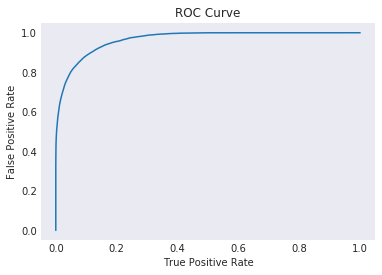

Training set ROC: 0.9659274470736187


In [212]:
lr_sample = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=40)
lr_sample_model = lr_sample.fit(sample_train)
trainingSummary_sample = lr_sample_model.summary

roc = trainingSummary_sample.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set ROC: ' + str(trainingSummary_sample.areaUnderROC))

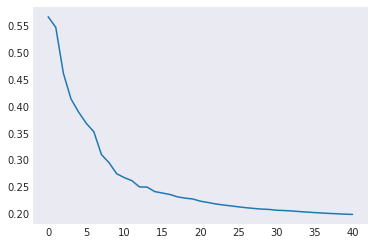

In [213]:
objectiveHistory = trainingSummary_sample.objectiveHistory
plt.plot(objectiveHistory)

In [214]:
objectiveHistory

[0.5670952164187564,
 0.5472669883925428,
 0.4617428672903857,
 0.41391146682897784,
 0.3894252575414534,
 0.36864472392015885,
 0.3527996941685815,
 0.3103149373156346,
 0.29509787274210597,
 0.2745285320079838,
 0.26728078888807066,
 0.26164690599077134,
 0.2499354996777363,
 0.2496756111951745,
 0.24126130637246973,
 0.2385883262374011,
 0.23578360543850788,
 0.23145938690586956,
 0.22900676244301033,
 0.22747080420531432,
 0.22336849193942454,
 0.22091403019932615,
 0.21822621368098943,
 0.2162742746537983,
 0.21460359923523903,
 0.21281114123480416,
 0.21120506092005295,
 0.20988146622360296,
 0.2086272780319473,
 0.20803525570428882,
 0.20649394406441238,
 0.20588673653054698,
 0.20512498149071307,
 0.20400414133451783,
 0.20299987632082245,
 0.20211842362797688,
 0.20129071365699017,
 0.20047964143053176,
 0.1999114113493004,
 0.1991333713955442,
 0.19868775203718336]

In [240]:
predictions_lr_sample = lr_sample_model.transform(sample_test)
evaluator = BinaryClassificationEvaluator()
print("Test_SET (Area Under ROC): " + str(evaluator.evaluate(predictions_lr_small, {evaluator.metricName: "areaUnderROC"})))

Test_SET (Area Under ROC): 0.607707493760864


In [241]:
lp_sample = predictions_lr_sample.select( "label", "prediction")
metricsCalc(lp_sample)

Number of records: 4693
trueP		389
trueN		2748
falseP		766
falseN		790
accuracy	0.6684423609631366
precision	0.3367965367965368
recall		0.3299406276505513
f1		0.33333333333333337


In [215]:
# Logisitic Regression with Regularization and Cross Validation for Hyperparameter Tuning

from pyspark.ml.tuning import CrossValidator, ParamGridBuilder 

lr_sample_reg = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=30)

paramGrid_lr = ParamGridBuilder() \
    .addGrid(lr_sample_reg.regParam, [0.01, 0.1, 1.0]) \
    .addGrid(lr_sample_reg.elasticNetParam, [0.5, 0.7, 0.9]) \
    .build()

crossval_lr_sample = CrossValidator(estimator=lr_sample_reg,
                             estimatorParamMaps=paramGrid_lr,
                             evaluator=BinaryClassificationEvaluator(),
                             numFolds=5)

#fit model to training data
lr_sample_reg_model = crossval_lr_sample.fit(sample_train)

#Transform test data
lr_sample_reg_result = lr_sample_reg_model.transform(sample_test)

#view id, label, prediction and probability from result of modeling
lr_sample_reg_result.select('label', 'prediction', 'probability').show(10)

+-----+----------+--------------------+
|label|prediction|         probability|
+-----+----------+--------------------+
|  0.0|       0.0|[0.86093309956908...|
|  0.0|       0.0|[0.78624045929843...|
|  0.0|       0.0|[0.66340766179395...|
|  0.0|       0.0|[0.80415387400538...|
|  0.0|       0.0|[0.92500406685746...|
|  0.0|       0.0|[0.91047920559785...|
|  0.0|       0.0|[0.77019355657222...|
|  0.0|       0.0|[0.53178235268030...|
|  0.0|       0.0|[0.71548453041274...|
|  0.0|       0.0|[0.79824553733723...|
+-----+----------+--------------------+
only showing top 10 rows



In [219]:
lr_sample_reg_model.getEstimatorParamMaps()[ np.argmax(lr_sample_reg_model.avgMetrics) ]

{Param(parent='LogisticRegression_4acc8b7ebc1be08bad7b', name='regParam', doc='regularization parameter (>= 0).'): 0.01,
 Param(parent='LogisticRegression_4acc8b7ebc1be08bad7b', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.5}

In [218]:
print('intercept:', lr_sample_reg_model.bestModel.intercept)
print('coefficients:', lr_sample_reg_model.bestModel.coefficients)

intercept: -1.1243246817948795
coefficients: (24135,[1,3,4,5,7,9,10,12,14,15,16,20,24,30,33,43,56,58,62,74,80,87,122,146,147,159,204,208,278,286,294,304,339,363,404,417,433,462,485,512,614,652,720,745,820,996,1008,1139,1180,1181,1203,1410,1487,1517,1593,1720,1779,1850,1928,1967,1969,1971,1972,1974,1975,1978,1990,1991,2009,2010,2026,2029,2033,2036,2049,2054,2069,2076,2091,2124,2149,2164,2214,2247,2325,2359,2377,2398,2489,2494,2503,2513,2554,2601,2646,2654,2806,2856,2872,2911,2960,3094,3151,3160,3179,3220,3241,3336,3355,3360,3367,3377,3379,3380,3381,3382,3411,3424,3431,3439,3449,3461,3465,3492,3494,3510,3530,3550,3633,3663,3685,3719,3740,3754,3783,3788,3797,3818,3819,3858,3862,3876,3902,3935,3944,3958,4024,4027,4030,4249,4251,4363,4448,4467,4473,4523,4686,4687,4702,4704,4705,4706,4708,4736,4757,4800,4809,4888,4901,5120,5124,5157,5170,5258,5316,5385,5410,5566,5719,5721,5777,5939,5949,6001,6201,6301,6421,6496,6526,6624,6653,6660,6710,6797,6828,6854,6967,7006,7045,7080,7213,7217,7220,7222,7

In [222]:
lp_reg_sample = lr_sample_reg_result.select( "label", "prediction")
metricsCalc(lp_reg_sample)

Number of records: 4693
trueP		136
trueN		3412
falseP		102
falseN		1043
accuracy	0.7560196036650331
precision	0.5714285714285714
recall		0.11535199321458864
f1		0.19195483415666903


### Read in the cvModel that Alex generated

In [9]:
from pyspark.ml.tuning import CrossValidatorModel
cvModel = CrossValidatorModel.load('gs://w261_desa2/notebooks/models/cvModel')

Note: This CV was run with ElasticNet parameters:  
$\lambda$ = 0.001, 0.01, 0.1, 1.0  
$\alpha$ = 0.001, 0.01, 0.1, 1.0 

In [10]:
cvModel.bestModel

LogisticRegression_43c78fe3323594615080

In [13]:
cvModel.bestModel.intercept

-1.0679078036687992

In [14]:
cvModel.bestModel.coefficients

DenseVector([0.158, 0.1221, 0.0312, -0.2281, -0.4735, -0.0396, 0.0925, -0.0813, -0.0241, 1.5481, 0.9241, 0.0275, -0.2001, 0.0033, 0.0489, -0.0462, -0.0613, 0.0603, -0.0442, 0.19, 0.0429, 0.4088, -0.001, 0.1097, 0.021, -0.0191, -0.0122, -0.2251, 0.0535, 0.0117, 0.2754, 0.0566, -0.0143, -0.0924, 0.1774, -0.0645, 0.1055, -0.0006, 0.3955, -0.0041, 0.0999, 0.0937, 0.116, -0.1432, 0.0345, 0.0349, -0.1502, -0.0034, 0.2055, 0.0707, -0.1308, -0.117, -0.0947, 0.1615, -0.1737, 0.0935, -0.1623, 0.2604, -0.0907, 0.0254, 0.016, -0.0143, -0.0228, -0.0252, 0.1492, -0.0838, 0.1931, 0.1002, -0.0177, -0.0534, 0.0135, 0.0339, -0.0782, 0.132, -0.0094, -0.2127, 0.2519, -0.1763, -0.1728, 0.0675, 0.1475, -0.0404, -0.0614, -0.0004, 0.0426, -0.0158, -0.0015, -0.0151, -0.0718, -0.0111, -0.0238, -0.0272, 0.0019, -0.0545, -0.0244, 0.0028, -0.0581, 0.0137, 0.0179, 0.0564, 0.0376, 0.0059, -0.0167, 0.0299, -0.0503, 0.0012, 0.1963, -0.0785, -0.0128, 0.0068, 0.0054, 0.0594, 0.0571, 0.1585, 0.006, -0.0011, 0.0413, 0.020

In [15]:
cvModel.getEstimatorParamMaps()

[{Param(parent='LogisticRegression_43c78fe3323594615080', name='regParam', doc='regularization parameter (>= 0).'): 0.001,
  Param(parent='LogisticRegression_43c78fe3323594615080', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.001},
 {Param(parent='LogisticRegression_43c78fe3323594615080', name='regParam', doc='regularization parameter (>= 0).'): 0.001,
  Param(parent='LogisticRegression_43c78fe3323594615080', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.01},
 {Param(parent='LogisticRegression_43c78fe3323594615080', name='regParam', doc='regularization parameter (>= 0).'): 0.001,
  Param(parent='LogisticRegression_43c78fe3323594615080', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 p

In [18]:
#cvModel.getNumFolds()
#cvModel.bestModel()

In [12]:
cvModel.avgMetrics

[]

In [19]:
#cvModel.getEstimatorParamMaps()[ np.argmax(cvModel.avgMetrics) ]

### Run the CV that Alex ran (from PreProcesing_Emily_Copy)

Note, this was only run with 2 levels for each hyperparameter, since it was informed by the results from the above cvModel run that Alex observed gave worse accuracy relative to the default values, which are 0.0, 0.0.  Therefore, we did this run on the extreme low end near zero to see if the bestModel picked hyperparameter values different than zero.  As shown below, it indeed picked $\lambda$ = 0.001 for the best result.  

In [20]:
tpp = spark.read.parquet('gs://w261_desa2/notebooks/data/toySampleTrain.parquet')
dpp = spark.read.parquet('gs://w261_desa2/notebooks/data/toySampleTest.parquet')
tpp.columns, dpp.columns

(['label', 'features', 'weightCol'], ['label', 'features'])

In [7]:
lr_sample_reg = LogisticRegression(
    featuresCol = 'features', 
    labelCol = 'label', 
    maxIter=10, 
    standardization=False
)

'''
lr_sample_reg = LogisticRegression(
    featuresCol = 'features', 
    labelCol = 'label', 
    weightCol = 'weightCol', 
    maxIter=10, 
    standardization=False)
'''
paramGrid_lr = ParamGridBuilder() \
    .addGrid(lr_sample_reg.regParam, [0.000, 0.001]) \
    .addGrid(lr_sample_reg.elasticNetParam, [0.000, 0.001]) \
    .build()

crossval_lr_sample = CrossValidator(
    estimator=lr_sample_reg,
    estimatorParamMaps=paramGrid_lr,
    evaluator=BinaryClassificationEvaluator()
)

#fit model to training data
lr_sample_reg_model = crossval_lr_sample.fit(tpp)

In [8]:
#Transform test data
lr_sample_reg_result = lr_sample_reg_model.transform(dpp)

#view id, label, prediction and probability from result of modeling
lr_sample_reg_result.select('label', 'prediction', 'probability').show(10)

+-----+----------+--------------------+
|label|prediction|         probability|
+-----+----------+--------------------+
|  0.0|       0.0|[0.91702852874526...|
|  0.0|       0.0|[0.51818982131679...|
|  0.0|       0.0|[0.85063532384838...|
|  0.0|       0.0|[0.88003037171912...|
|  0.0|       0.0|[0.65511546044695...|
|  0.0|       0.0|[0.91582283648407...|
|  0.0|       0.0|[0.84256585960662...|
|  0.0|       0.0|[0.80445812139920...|
|  0.0|       0.0|[0.62212235696704...|
|  0.0|       0.0|[0.60589380037474...|
+-----+----------+--------------------+
only showing top 10 rows



In [25]:
def metricsCalc(lp):
    '''
    Calculate binary classification metrics
    '''
    
    trueP = lp.filter(lp["prediction"] == 1.0).filter(lp["label"] == lp["prediction"]).count()
    trueN = lp.filter(lp["prediction"] == 0.0).filter(lp["label"] == lp["prediction"]).count()
    falseP = lp.filter(lp["prediction"] == 1.0).filter(lp["label"] != lp["prediction"]).count()
    falseN = lp.filter(lp["prediction"] == 0.0).filter(lp["label"] != lp["prediction"]).count()

    # Calculate precision, recall, accuracy, and F1
    precision = float(trueP)/(trueP + falseP) # aka specificity
    recall = float(trueP)/(trueP + falseN)  # aka sensitivity
    accuracy = float(trueP + trueN)/(trueP + trueN + falseP + falseN)
    if trueP != 0:
        f1 = 2 * (precision * recall) / (precision + recall)  # if trueP=0, then precision=0 and recall=0, so f1 doesn't work.
    else:
        f1 = 'TP=0 so cannot calc f1'

    # prints
    print('Number of records:', (trueP+falseP+trueN+falseN))
    print(f'trueP\t\t{trueP}')
    print(f'trueN\t\t{trueN}')
    print(f'falseP\t\t{falseP}')
    print(f'falseN\t\t{falseN}')
    print(f'accuracy\t{accuracy}')
    print(f'precision\t{precision}')
    print(f'recall\t\t{recall}')
    print(f'f1\t\t{f1}')

In [10]:
lp_reg = lr_sample_reg_result.select( "label", "prediction")
metricsCalc(lp_reg)

Number of records: 427
trueP		31
trueN		284
falseP		17
falseN		95
accuracy	0.7377049180327869
precision	0.6458333333333334
recall		0.24603174603174602
f1		0.3563218390804597


In [11]:
lr_sample_reg_model.getEstimatorParamMaps()[ np.argmax(lr_sample_reg_model.avgMetrics) ]

{Param(parent='LogisticRegression_43bda9c3e9b32eb32bd4', name='regParam', doc='regularization parameter (>= 0).'): 0.001,
 Param(parent='LogisticRegression_43bda9c3e9b32eb32bd4', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.0}

In [ ]:
#lr_sample_reg_model.save('gs://w261_desa2/notebooks/models/cvModel')

##### RESULT of CV: accuracy = 0.74 with \lambda = 0.001 and \alpha = 0.0.

### Run CV on sample with weighted LR

In [28]:
'''
lr_sample_reg = LogisticRegression(
    featuresCol = 'features', 
    labelCol = 'label', 
    maxIter=10, 
    standardization=False
)
'''
#'''
lr_sample_reg = LogisticRegression(
    featuresCol = 'features', 
    labelCol = 'label', 
    weightCol = 'weightCol', 
    maxIter=10, 
    standardization=False
)
#'''
paramGrid_lr = ParamGridBuilder() \
    .addGrid(lr_sample_reg.regParam, [0.000, 0.001, 0.01, 0.05]) \
    .addGrid(lr_sample_reg.elasticNetParam, [0.000, 0.001, 0.01, 0.05]) \
    .build()

crossval_lr_sample = CrossValidator(
    estimator=lr_sample_reg,
    estimatorParamMaps=paramGrid_lr,
    evaluator=BinaryClassificationEvaluator()
)

#fit model to training data
lr_sample_reg_model_wts = crossval_lr_sample.fit(tpp)

In [29]:
#Transform test data
lr_sample_reg_result_wts = lr_sample_reg_model_wts.transform(dpp)

#view id, label, prediction and probability from result of modeling
lr_sample_reg_result_wts.select('label', 'prediction', 'probability').show(10)

+-----+----------+--------------------+
|label|prediction|         probability|
+-----+----------+--------------------+
|  0.0|       0.0|[0.64951054587606...|
|  0.0|       1.0|[0.42566883351059...|
|  0.0|       0.0|[0.55886062859781...|
|  0.0|       0.0|[0.75881015995436...|
|  0.0|       1.0|[0.44812584622292...|
|  0.0|       0.0|[0.69826355395568...|
|  0.0|       0.0|[0.56111108710034...|
|  0.0|       0.0|[0.65383961250815...|
|  0.0|       1.0|[0.41599436180322...|
|  0.0|       1.0|[0.44284726077542...|
+-----+----------+--------------------+
only showing top 10 rows



In [30]:
lp_reg = lr_sample_reg_result_wts.select( "label", "prediction")
metricsCalc(lp_reg)

Number of records: 427
trueP		79
trueN		209
falseP		92
falseN		47
accuracy	0.6744730679156908
precision	0.4619883040935672
recall		0.626984126984127
f1		0.5319865319865319


Obviously, the weighted results are not as good as the unweighted.

In [31]:
lr_sample_reg_model_wts.getEstimatorParamMaps()[ np.argmax(lr_sample_reg_model_wts.avgMetrics) ]

{Param(parent='LogisticRegression_41799a9058d23352c589', name='regParam', doc='regularization parameter (>= 0).'): 0.01,
 Param(parent='LogisticRegression_41799a9058d23352c589', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.001}

## Read full training and test data and apply Logistic Regression

In [13]:
train = spark.read.parquet('gs://w261_desa2/notebooks/data/trainProcessed.parquet')
test = spark.read.parquet('gs://w261_desa2/notebooks/data/testProcessed.parquet')

In [14]:
train.head()

Row(label=0.0, features=SparseVector(806981, {156: 1.0, 12535: 1.0, 12753: 1.0, 19354: 1.0, 35037: 1.0, 133078: 1.0, 133481: 1.0, 136576: 1.0, 212102: 1.0, 313588: 1.0, 411679: 1.0, 411685: 1.0, 411703: 1.0, 411723: 1.0, 414082: 1.0, 512854: 1.0, 520086: 1.0, 521530: 1.0, 615070: 1.0, 706347: 1.0, 707394: 1.0}), weightCol=0.25621744990348816)

In [15]:
test.head()

Row(label=0.0, features=SparseVector(806981, {90: 1.0, 12535: 1.0, 12645: 1.0, 19396: 1.0, 114451: 1.0, 133077: 1.0, 133469: 1.0, 136576: 1.0, 211551: 1.0, 238784: 1.0, 350583: 1.0, 411679: 1.0, 411685: 1.0, 411697: 1.0, 411972: 1.0, 428999: 1.0, 512762: 1.0, 520084: 1.0, 521530: 1.0, 615070: 1.0, 706348: 1.0, 710127: 1.0}))

In [225]:
train.columns

In [17]:
train.distinct().count()

41234939

In [16]:
test.distinct().count()

4587391

In [229]:
# Non-CV version

lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=40)
lr_model = lr.fit(train)
trainingSummary = lr_model.summary

roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set ROC: ' + str(trainingSummary.areaUnderROC))

"lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=40)\nlr_model = lr.fit(train)\ntrainingSummary = lr_model.summary\n\nroc = trainingSummary.roc.toPandas()\nplt.plot(roc['FPR'],roc['TPR'])\nplt.ylabel('False Positive Rate')\nplt.xlabel('True Positive Rate')\nplt.title('ROC Curve')\nplt.show()\nprint('Training set ROC: ' + str(trainingSummary.areaUnderROC))\n"

In [230]:
objectiveHistory = trainingSummary.objectiveHistory
plt.plot(objectiveHistory)

In [231]:
objectiveHistory

In [ ]:
# Non-CV run

predictions_lr = lr_model.transform(test)
evaluator = BinaryClassificationEvaluator()
print("Test_SET (Area Under ROC): " + str(evaluator.evaluate(predictions_lr, {evaluator.metricName: "areaUnderROC"})))

In [ ]:
lp_full = predictions_lr.select( "label", "prediction")
metricsCalc(lp_full)

Run below with $\lambda$ = 0.001 and $\alpha$ = 0.0, based on the hyperparameter tuning above (unweighted) done on the sample data.  

In [18]:
# Logisitic Regression with Regularization and Cross Validation for Hyperparameter Tuning

from pyspark.ml.tuning import CrossValidator, ParamGridBuilder 

lr_reg = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=30)

paramGrid_lr = ParamGridBuilder() \
    .addGrid(lr_reg.regParam, [0.001]) \
    .addGrid(lr_reg.elasticNetParam, [0.0]) \
    .build()

crossval_lr = CrossValidator(estimator=lr_reg,
                             estimatorParamMaps=paramGrid_lr,
                             evaluator=BinaryClassificationEvaluator(),
                             numFolds=5)

#fit model to training data
lr_reg_model = crossval_lr.fit(train)

#Transform test data
lr_reg_result = lr_reg_model.transform(test)

#view id, label, prediction and probability from result of modeling
lr_reg_result.select('label', 'prediction', 'probability').show(10)


+-----+----------+--------------------+
|label|prediction|         probability|
+-----+----------+--------------------+
|  0.0|       0.0|[0.90175615546890...|
|  0.0|       0.0|[0.74411407594441...|
|  0.0|       0.0|[0.97631520901880...|
|  0.0|       0.0|[0.97374281970219...|
|  0.0|       1.0|[0.40851486911468...|
|  0.0|       0.0|[0.71834811786216...|
|  0.0|       0.0|[0.92212408812388...|
|  0.0|       0.0|[0.95423178577135...|
|  0.0|       0.0|[0.94699554388450...|
|  0.0|       0.0|[0.68850688970982...|
+-----+----------+--------------------+
only showing top 10 rows



In [19]:
lr_reg_model.getEstimatorParamMaps()[ np.argmax(lr_reg_model.avgMetrics) ]

{Param(parent='LogisticRegression_4d698991557597982245', name='regParam', doc='regularization parameter (>= 0).'): 0.001,
 Param(parent='LogisticRegression_4d698991557597982245', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.0}

In [20]:
print('intercept:', lr_reg_model.bestModel.intercept)
#print('coefficients:', lr_reg_model.bestModel.coefficients)

intercept: -1.0492294422752777
coefficients: 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [21]:
lp_reg = lr_reg_result.select( "label", "prediction")
metricsCalc(lp_reg)

Number of records: 4587917
trueP		429346
trueN		3160106
falseP		252035
falseN		746430
accuracy	0.7823707360006731
precision	0.63011149415672
recall		0.365159690281142
f1		0.4623690942661283


In [23]:
lr_reg_model.save('gs://w261_desa2/notebooks/models/regFullModel_Steve')